# Adonis analysis

+ **目的**：用adnonis统计分析每个数据集两个组之间beta多样性的差异并统计这两组在数据集中的差异总效应值
+ **方法参考**：Meta-analysis reveals reproducible gut microbiome alterations in response to a high-fat diet. 您可以点击[这里](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6708278/)获取原文。 

In [2]:
library(vegan) #for adonis analysis
library(ggplot2)
library(tidyverse)
#library(MicrobeR)

In [4]:
#colors for plotting
col <- c("#E69F00",
         "#0072B2",
         "#D6604D",
         "#7570B3")

## read distance

In [5]:
bc=read.csv('distance/Bray-Curtis-distance.tsv',sep='\t',row.names=1)
jaccard=read.csv('distance/Jaccard-distance.tsv',sep='\t',row.names=1)
unweightUF=read.csv('distance/unweighted_unifrac_distance-distance.tsv',sep='\t',row.names=1)
weightUF=read.csv('distance/weighted_unifrac_distance-distance.tsv',sep='\t',row.names=1)

In [6]:
distance_metric <- list(bc,jaccard,weightUF,unweightUF)
distance_str <- c('Bray Curtis','Jaccard','Weighted UniFrac','Unweighted UniFrac')

In [7]:
head(bc,2)

,ERR1995049,ERR1995038,ERR1995100,ERR1995099,ERR1995073,ERR1994996,ERR1995111,ERR1994997,ERR1995023,ERR1995109,⋯,SRR8031281,SRR8031243,SRR8031248,SRR8031257,SRR8031263,SRR8031285,SRR8031235,SRR8031264,SRR8031256,SRR8031271
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ERR1995049,0.000,0.768,0.906,0.929,0.915,0.720,0.923,0.479,0.477,0.864,⋯,0.999,1,0.998,0.999,0.997,1,1,0.999,0.997,0.996
ERR1995038,0.768,0.000,0.794,0.881,0.807,0.999,0.891,0.846,0.847,0.812,⋯,1.000,1,0.999,0.999,0.998,1,1,0.999,0.997,0.999


## read metadata

In [8]:

md <- read.csv('metadata.tsv',row.names=1,sep='\t') 
head(md,2)

,Age,BMI,BioProject,CagA,Center_Name,Collection_Date,Condition,Country,Diagnosis,Gender,⋯,gastrin,host_height,host_weight,hp,hp_relative_abundance,paried.sample,primer,sampleloc,sampling_method,smoker
,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
ERR1995049,NA,,PRJEB21104,,CGR,,gastric cancer,United Kingdom,gastric cancer,,⋯,M100,NA,NA,positive,78.20510,,27F _388R,,gastric mucosa biopsy,
ERR1995038,NA,,PRJEB21104,,CGR,,gastric cancer,United Kingdom,gastric cancer,,⋯,M100,NA,NA,positive,11.57239,,27F _388R,,gastric mucosa biopsy,


In [9]:
table(md$Study)


                PRJEB21104                 PRJEB21497 
                       128                         36 
                PRJEB22107                 PRJEB26931 
                        32                        310 
         PRJNA310127_China         PRJNA310127_Mexico 
                       157                        134 
               PRJNA313391 PRJNA375772_Inner_Mongolia 
                       120                        143 
         PRJNA375772_Xi_an                PRJNA428883 
                       201                        745 
               PRJNA481413                PRJNA495436 
                       417                         58 

In [10]:
study=unique(md$Study)
study

[1] "PRJEB21104"                 "PRJEB21497"                
 [3] "PRJEB22107"                 "PRJEB26931"                
 [5] "PRJNA310127_China"          "PRJNA310127_Mexico"        
 [7] "PRJNA313391"                "PRJNA375772_Inner_Mongolia"
 [9] "PRJNA375772_Xi_an"          "PRJNA495436"               
[11] "PRJNA428883"                "PRJNA481413"

## Adonis analysis for each two disease stage

In [11]:
# function gain each study each distance adonis results

beta_stat <- function(p,dis,c1,c2){
    
    As <- list()
    s_md <- subset(md,Study==p) %>% subset(Diagnosis==c1| Diagnosis==c2)
    sample_ids=intersect(row.names(s_md),row.names(dis))
    s_md <- s_md[sample_ids,]
    distance <- dis[sample_ids,sample_ids]
    
    adnonis_res <- adonis(distance ~ Diagnosis, data = s_md)$aov.tab
    return(adnonis_res)
}

### healthy vs gastritis 

In [12]:
#排除不想分析的样本
md <- subset(md,Condition!='atrophic gastritis') %>%subset(Condition!='H.pylori atrophic gastritis')

In [13]:
dim(md)

[1] 2351   50

In [14]:
#三个数据集中有健康和胃炎的样本，本示例以分析这三个数据集健康和胃炎样本的beta多样性差异为例
Project=c('PRJEB21104','PRJEB22107','PRJEB26931')

In [15]:
# 每个数据集分别健康和胃炎比较
set.seed(1)
PerStudy_beta<-list()
for (i in 1:4){
    dis <- distance_metric[[i]]
    dis_str <- distance_str[i]
    #message(dis_str)
    for(p in Project){        
        #message(p)
        PerStudy_beta[[dis_str]][[p]]<-beta_stat(p,dis,'healthy','gastritis')
   }
}

In [16]:
#把结果整理成data.frame
data <- data.frame()

for (dis_str in distance_str){
   diag_res <- data.frame(row.names=Project) 
   for (p in Project){       
       diag_res[p,1] <- PerStudy_beta[[dis_str]][[p]]['Diagnosis','R2']
       diag_res[p,2] <- PerStudy_beta[[dis_str]][[p]]['Diagnosis','Pr(>F)'] 
   }   
   names(diag_res) <- c('R2','pvalue')
   diag_res['study']<-row.names(diag_res)
   diag_res['metric'] <- dis_str
   data <- rbind(data, diag_res)      #   
}


# combined:把三个数据集的distance和metadata都筛选出来，adonis分析多加一个参数strata
mtd <- subset(md,Study == 'PRJEB21104' | Study == 'PRJEB22107' | Study == 'PRJEB26931') %>% 
subset(Diagnosis == 'healthy'| Diagnosis == 'gastritis')

df <- data.frame()
for (i in 1:4){
    dis <- distance_metric[[i]]
    dis_str <- distance_str[i]
    
    sample_ids = intersect(row.names(mtd),row.names(dis))
    s_md <- mtd[sample_ids,]
    distance <- dis[sample_ids,sample_ids]
    adnonis_res <- adonis(distance ~ Diagnosis, strata=s_md$Study,data = s_md)$aov.tab ## strata设为study
    R2 <- adnonis_res['Diagnosis','R2']
    pvalue <- adnonis_res['Diagnosis','Pr(>F)']
    l <- data.frame('R2'=R2,'pvalue'=pvalue,'study'='Combined','metric'=dis_str)
    df <- rbind(df, l)
    
}

hg <- rbind(data,df) %>% mutate(Compare='Healthy vs. Gastritis') %>% mutate(Pvalue=case_when(
pvalue < 0.05 ~'P < 0.05',  
TRUE~"ns"
))

In [17]:
hg

,R2,pvalue,study,metric,Compare,Pvalue
,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
PRJEB21104,0.27329481,0.001,PRJEB21104,Bray Curtis,Healthy vs. Gastritis,P < 0.05
PRJEB22107,0.09087176,0.049,PRJEB22107,Bray Curtis,Healthy vs. Gastritis,P < 0.05
PRJEB26931,0.25617726,0.001,PRJEB26931,Bray Curtis,Healthy vs. Gastritis,P < 0.05
PRJEB211041,0.11330168,0.001,PRJEB21104,Jaccard,Healthy vs. Gastritis,P < 0.05
PRJEB221071,0.04613104,0.249,PRJEB22107,Jaccard,Healthy vs. Gastritis,ns
PRJEB269311,0.14589424,0.001,PRJEB26931,Jaccard,Healthy vs. Gastritis,P < 0.05
PRJEB211042,0.71211405,0.001,PRJEB21104,Weighted UniFrac,Healthy vs. Gastritis,P < 0.05
PRJEB221072,0.04339932,0.356,PRJEB22107,Weighted UniFrac,Healthy vs. Gastritis,ns
PRJEB269312,0.03633489,0.050,PRJEB26931,Weighted UniFrac,Healthy vs. Gastritis,ns


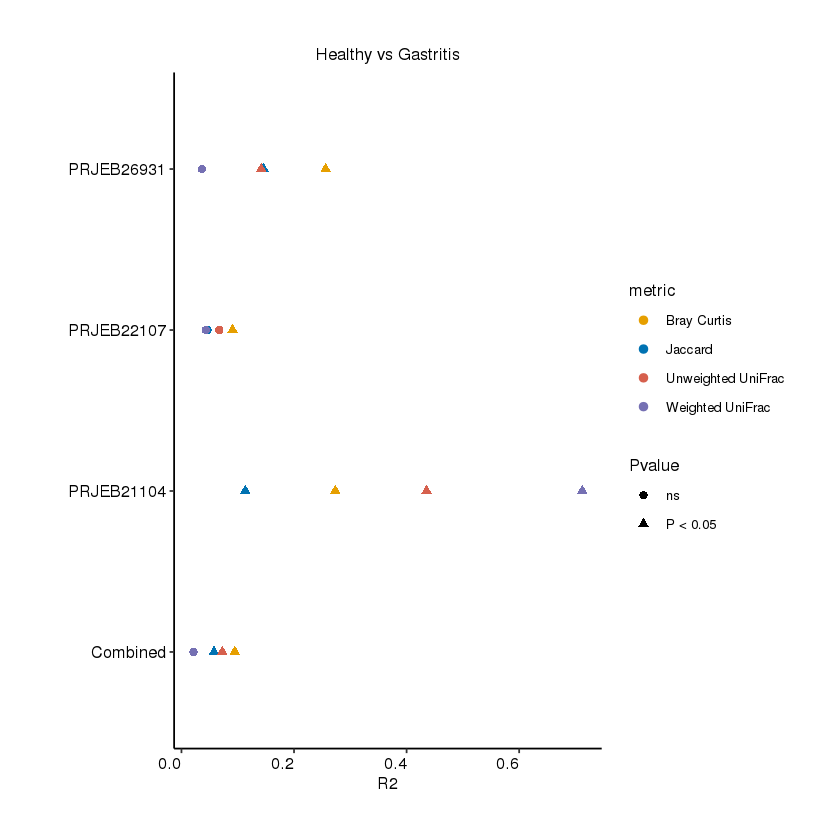

In [18]:
ggplot(data = hg, aes(x = R2, y =study,color=metric))+ geom_point(aes(shape =Pvalue),size=2)+
theme_bw() +
theme(panel.border = element_blank(), axis.line = element_line())+ #上右方框去掉了
theme(axis.text.x = element_text(angle = 0, hjust = 1), 
        panel.grid = element_blank(), 
        axis.text = element_text(size = 10,colour = 'black'), 
        axis.title = element_text(size = 10),
        plot.title = element_text(size = 10,hjust = 0.5),
      legend.title = element_text(size = 10),
      legend.text = element_text(size = 8),
     plot.margin=unit(rep(2,4),'lines'))+scale_color_manual(values=col)+
labs(title = 'Healthy vs Gastritis',y='') #
#ggsave("figures/healthy_vs_gastritis_adonis-no313391.pdf", device="pdf", height=3, width=5.2, useDingbats=F)

**-------------------end-------------------**   
后面全是重复代码，请忽略

### healthy vs GC

In [41]:
Project=c('PRJEB21104','PRJEB21497','PRJEB26931')

In [42]:
set.seed(1)
PerStudy_beta<-list()
for (i in 1:4){
    dis <- distance_metric[[i]]
    dis_str <- distance_str[i]
    #message(dis_str)
    for(p in Project){
        
        #message(p)
        PerStudy_beta[[dis_str]][[p]]<-beta_stat(p,dis,'healthy','gastric cancer')
   }
}

In [43]:
data <- data.frame()

for (dis_str in distance_str){
   diag_res <- data.frame(row.names=Project) 
   for (p in Project){       
       diag_res[p,1] <- PerStudy_beta[[dis_str]][[p]]['Diagnosis','R2']
       diag_res[p,2] <- PerStudy_beta[[dis_str]][[p]]['Diagnosis','Pr(>F)'] 
   }   
   names(diag_res) <- c('R2','pvalue')
   diag_res['study']<-row.names(diag_res)
   diag_res['metric'] <- dis_str
   data <- rbind(data, diag_res)      #   
}

# combined 
mtd <- subset(md,Study == 'PRJEB21104' | Study == 'PRJEB21497' | Study == 'PRJEB26931') %>% 
subset(Diagnosis == 'healthy'| Diagnosis == 'gastric cancer')

df <- data.frame()
for (i in 1:4){
    dis <- distance_metric[[i]]
    dis_str <- distance_str[i]
    
    sample_ids = intersect(row.names(mtd),row.names(dis))
    s_md <- mtd[sample_ids,]
    distance <- dis[sample_ids,sample_ids]
    adnonis_res <- adonis(distance ~ Diagnosis, strata=s_md$Study,data = s_md)$aov.tab
    R2 <- adnonis_res['Diagnosis','R2']
    pvalue <- adnonis_res['Diagnosis','Pr(>F)']
    l <- data.frame('R2'=R2,'pvalue'=pvalue,'study'='Combined','metric'=dis_str)
    df <- rbind(df, l)
    
}

hgc <- rbind(data,df) %>% mutate(Compare='Healthy vs. GC') %>% #
mutate(Pvalue=case_when(pvalue < 0.05 ~'P < 0.05', TRUE~"ns"))

In [44]:
hgc

,R2,pvalue,study,metric,Compare,Pvalue
,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
PRJEB21104,0.15140261,0.001,PRJEB21104,Bray Curtis,Healthy vs. GC,P < 0.05
PRJEB21497,0.07576004,0.002,PRJEB21497,Bray Curtis,Healthy vs. GC,P < 0.05
PRJEB26931,0.16024839,0.001,PRJEB26931,Bray Curtis,Healthy vs. GC,P < 0.05
PRJEB211041,0.07002183,0.001,PRJEB21104,Jaccard,Healthy vs. GC,P < 0.05
PRJEB214971,0.05157238,0.001,PRJEB21497,Jaccard,Healthy vs. GC,P < 0.05
PRJEB269311,0.12527220,0.001,PRJEB26931,Jaccard,Healthy vs. GC,P < 0.05
PRJEB211042,0.33773866,0.001,PRJEB21104,Weighted UniFrac,Healthy vs. GC,P < 0.05
PRJEB214972,0.03956723,0.258,PRJEB21497,Weighted UniFrac,Healthy vs. GC,ns
PRJEB269312,0.06605080,0.001,PRJEB26931,Weighted UniFrac,Healthy vs. GC,P < 0.05


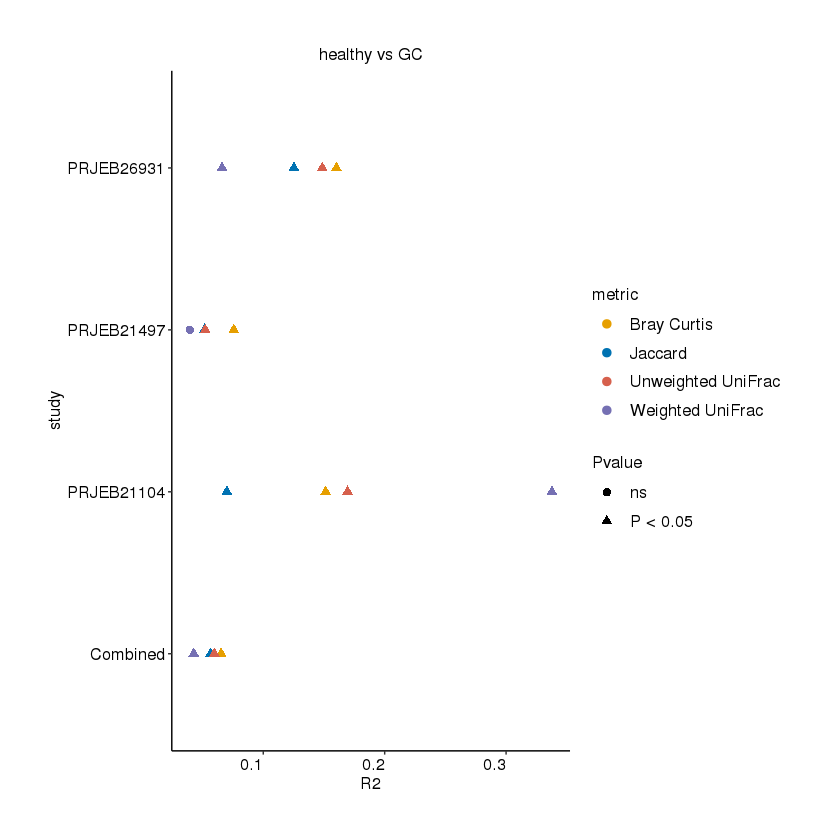

In [45]:
ggplot(data = hgc, aes(x = R2, y =study,color=metric))+ geom_point(aes(shape =Pvalue),size=2)+
theme_MicrobeR() +
theme(panel.border = element_blank(), axis.line = element_line())+ #上右方框去掉了
theme(axis.text.x = element_text(angle = 0, hjust = 1), 
        panel.grid = element_blank(), 
        axis.text = element_text(size = 10,colour = 'black'), 
        axis.title = element_text(size = 10),
        plot.title = element_text(size = 10,hjust = 0.5),
        legend.title = element_text(size = 10),
      legend.text = element_text(size = 10),
     plot.margin=unit(rep(2,4),'lines')
     )+labs(title = 'healthy vs GC') +scale_color_manual(values=col)#
ggsave("figures/healthy_vs_GC_adonis-no313391.pdf", device="pdf", height=3, width=6, useDingbats=F)

### gastritis vs IM 

In [46]:
dim(md)

[1] 2092   50

In [47]:
Project=c('PRJEB21104','PRJEB26931','PRJNA375772_Xi_an','PRJNA481413')

In [48]:
table(md$Diagnosis)


       gastric cancer             gastritis               healthy 
                 1392                   370                   104 
intestinal metaplasia 
                  226 

In [49]:
set.seed(1)
PerStudy_beta<-list()
for (i in 1:4){
    dis <- distance_metric[[i]]
    dis_str <- distance_str[i]
    #message(dis_str)
    for(p in Project){
        
        #message(p)
        PerStudy_beta[[dis_str]][[p]]<-beta_stat(p,dis,'gastritis','intestinal metaplasia')
   }
}

In [50]:
data <- data.frame()

for (dis_str in distance_str){
   diag_res <- data.frame(row.names=Project) 
   for (p in Project){       
       diag_res[p,1] <- PerStudy_beta[[dis_str]][[p]]['Diagnosis','R2']
       diag_res[p,2] <- PerStudy_beta[[dis_str]][[p]]['Diagnosis','Pr(>F)'] 
   }   
   names(diag_res) <- c('R2','pvalue')
   diag_res['study']<-row.names(diag_res)
   diag_res['metric'] <- dis_str
   data <- rbind(data, diag_res)         
}

# combined 
mtd <- subset(md,Study == 'PRJEB21104' | Study == 'PRJEB26931' | Study == 'PRJNA375772_Xi_an' | Study == 'PRJNA481413') %>%
subset(Diagnosis == 'gastritis'| Diagnosis == 'intestinal metaplasia')  #

df <- data.frame()
for (i in 1:4){
    dis <- distance_metric[[i]]
    dis_str <- distance_str[i]
    
    sample_ids = intersect(row.names(mtd),row.names(dis))
    s_md <- mtd[sample_ids,]
    distance <- dis[sample_ids,sample_ids]
    adnonis_res <- adonis(distance ~ Diagnosis, strata=s_md$Study,data = s_md)$aov.tab
    R2 <- adnonis_res['Diagnosis','R2']
    pvalue <- adnonis_res['Diagnosis','Pr(>F)']
    l <- data.frame('R2'=R2,'pvalue'=pvalue,'study'='Combined','metric'=dis_str)
    df <- rbind(df, l)
    
}

gIM <- rbind(data,df) %>% mutate(Compare='Gastritis vs. IM') %>%                                        #
mutate(Pvalue=case_when(pvalue < 0.05 ~'P < 0.05', TRUE~"ns"))

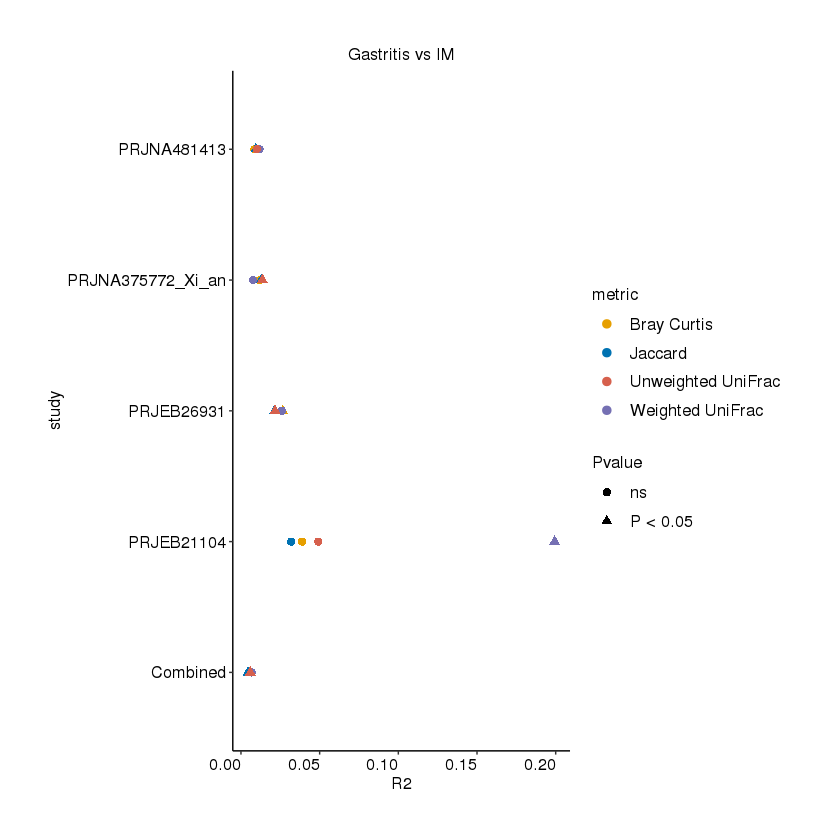

In [51]:
ggplot(data =gIM , aes(x = R2, y =study,color=metric))+ geom_point(aes(shape =Pvalue),size=2)+
theme_MicrobeR() +
theme(panel.border = element_blank(), axis.line = element_line())+ #上右方框去掉了
theme(axis.text.x = element_text(angle = 0, hjust = 1), 
        panel.grid = element_blank(), 
        axis.text = element_text(size = 10,colour = 'black'), 
        axis.title = element_text(size = 10),
        plot.title = element_text(size = 10,hjust = 0.5),
        legend.title = element_text(size = 10),
      legend.text = element_text(size = 10),
     plot.margin=unit(rep(2,4),'lines')
     )+labs(title = 'Gastritis vs IM') +scale_color_manual(values=col)#
ggsave("figures/gastritis_vs_IM_adonis-no313391.pdf", device="pdf", height=3, width=6, useDingbats=F)

### gastritis vs GC 

In [52]:
Project<-c('PRJEB21104','PRJEB26931','PRJNA375772_Inner_Mongolia','PRJNA375772_Xi_an',
'PRJNA481413')

In [53]:
set.seed(1)
PerStudy_beta<-list()
for (i in 1:4){
    dis <- distance_metric[[i]]
    dis_str <- distance_str[i]
    #message(dis_str)
    for(p in Project){
        
        #message(p)
        PerStudy_beta[[dis_str]][[p]]<-beta_stat(p,dis,'gastritis','gastric cancer')  #
   }
}

In [54]:
data <- data.frame()

for (dis_str in distance_str){
   diag_res <- data.frame(row.names=Project) 
   for (p in Project){       
       diag_res[p,1] <- PerStudy_beta[[dis_str]][[p]]['Diagnosis','R2']
       diag_res[p,2] <- PerStudy_beta[[dis_str]][[p]]['Diagnosis','Pr(>F)'] 
   }   
   names(diag_res) <- c('R2','pvalue')
   diag_res['study']<-row.names(diag_res)
   diag_res['metric'] <- dis_str
   data <- rbind(data, diag_res)         
}

# combined 
mtd <- subset(md,Study == 'PRJEB21104' | Study == 'PRJEB26931' | Study == 'PRJNA375772_Inner_Mongolia'| Study == 'PRJNA375772_Xi_an' | Study == 'PRJNA481413') %>%
subset(Diagnosis == 'gastritis'| Diagnosis == 'gastric cancer')  #

df <- data.frame()
for (i in 1:4){
    dis <- distance_metric[[i]]
    dis_str <- distance_str[i]
    
    sample_ids = intersect(row.names(mtd),row.names(dis))
    s_md <- mtd[sample_ids,]
    distance <- dis[sample_ids,sample_ids]
    adnonis_res <- adonis(distance ~ Diagnosis,strata=s_md$Study, data = s_md)$aov.tab
    R2 <- adnonis_res['Diagnosis','R2']
    pvalue <- adnonis_res['Diagnosis','Pr(>F)']
    l <- data.frame('R2'=R2,'pvalue'=pvalue,'study'='Combined','metric'=dis_str)
    df <- rbind(df, l)
    
}

ggc <- rbind(data,df) %>% mutate(Compare='Gastritis vs. GC') %>%                                        #
mutate(Pvalue=case_when(pvalue < 0.05 ~'P < 0.05', TRUE~"ns"))

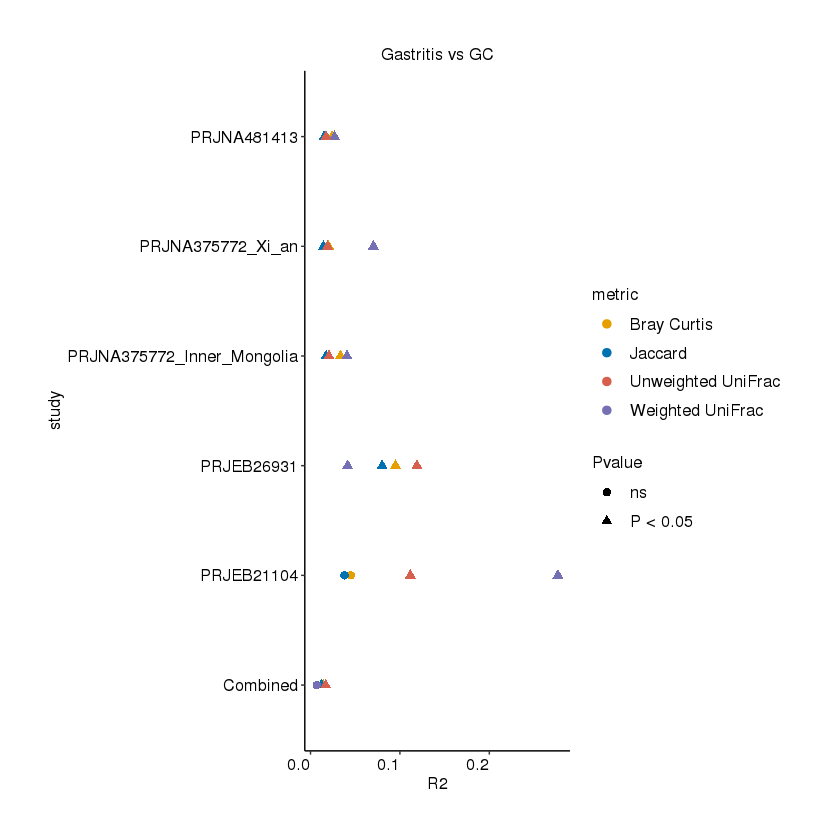

In [55]:
ggplot(data =ggc , aes(x = R2, y =study,color=metric))+ geom_point(aes(shape =Pvalue),size=2)+
theme_MicrobeR() +
theme(panel.border = element_blank(), axis.line = element_line())+ #上右方框去掉了
theme(axis.text.x = element_text(angle = 0, hjust = 1), 
        panel.grid = element_blank(), 
        axis.text = element_text(size = 10,colour = 'black'), 
        axis.title = element_text(size = 10),
        plot.title = element_text(size = 10,hjust = 0.5),
        legend.title = element_text(size = 10),
      legend.text = element_text(size = 10),
     plot.margin=unit(rep(2,4),'lines')
     )+labs(title = 'Gastritis vs GC') +scale_color_manual(values=col)
ggsave("figures/gastritis_vs_GC_adonis-no313391.pdf", device="pdf", height=3.5, width=6.8, useDingbats=F)

### IM vs GC 

In [56]:
Project<-c('PRJEB21104','PRJEB26931','PRJNA375772_Xi_an',
'PRJNA481413')

In [57]:
set.seed(1)
PerStudy_beta<-list()
for (i in 1:4){
    dis <- distance_metric[[i]]
    dis_str <- distance_str[i]
    #message(dis_str)
    for(p in Project){
        
        #message(p)
        PerStudy_beta[[dis_str]][[p]]<-beta_stat(p,dis,'intestinal metaplasia','gastric cancer')
   }
}

In [58]:
data <- data.frame()

for (dis_str in distance_str){
   diag_res <- data.frame(row.names=Project) 
   for (p in Project){       
       diag_res[p,1] <- PerStudy_beta[[dis_str]][[p]]['Diagnosis','R2']
       diag_res[p,2] <- PerStudy_beta[[dis_str]][[p]]['Diagnosis','Pr(>F)'] 
   }   
   names(diag_res) <- c('R2','pvalue')
   diag_res['study']<-row.names(diag_res)
   diag_res['metric'] <- dis_str
   data <- rbind(data, diag_res)         
}

# combined 
mtd <- subset(md,Study == 'PRJEB21104' | Study == 'PRJEB26931' | Study == 'PRJNA375772_Xi_an' | Study == 'PRJNA481413') %>%
subset(Diagnosis == 'intestinal metaplasia'| Diagnosis == 'gastric cancer')  #

df <- data.frame()
for (i in 1:4){
    dis <- distance_metric[[i]]
    dis_str <- distance_str[i]
    
    sample_ids = intersect(row.names(mtd),row.names(dis))
    s_md <- mtd[sample_ids,]
    distance <- dis[sample_ids,sample_ids]
    adnonis_res <- adonis(distance ~ Diagnosis,strata=s_md$Study, data = s_md)$aov.tab
    R2 <- adnonis_res['Diagnosis','R2']
    pvalue <- adnonis_res['Diagnosis','Pr(>F)']
    l <- data.frame('R2'=R2,'pvalue'=pvalue,'study'='Combined','metric'=dis_str)
    df <- rbind(df, l)
    
}

IMGC <- rbind(data,df) %>% mutate(Compare='IM vs. GC') %>%                                        #
mutate(Pvalue=case_when(pvalue < 0.05 ~'P < 0.05', TRUE~"ns"))

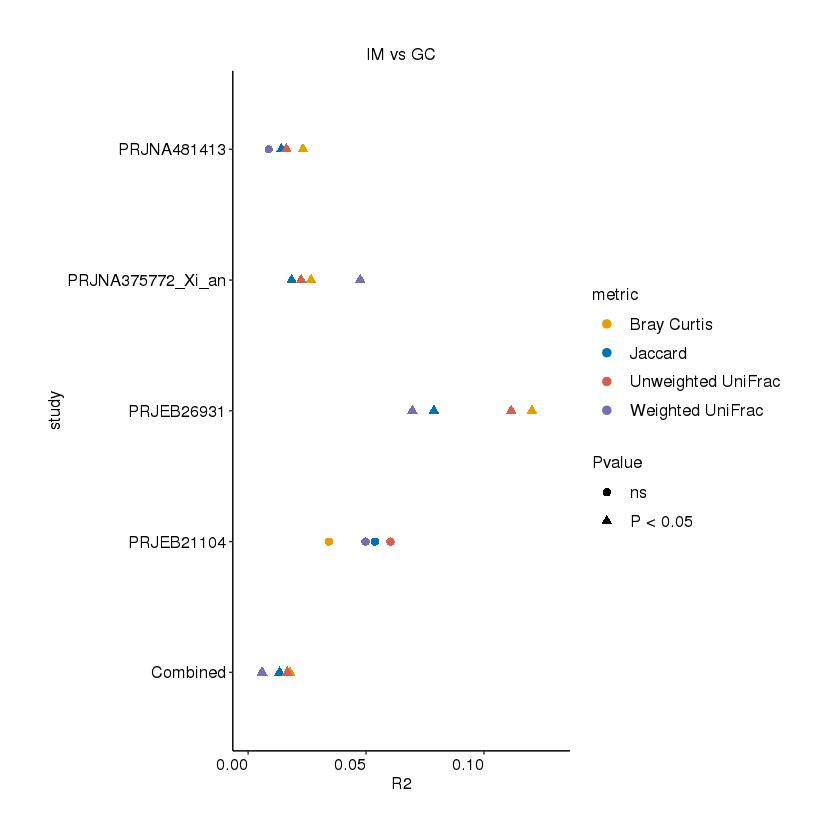

In [59]:
ggplot(data =IMGC , aes(x = R2, y =study,color=metric))+ geom_point(aes(shape =Pvalue),size=2)+
theme_MicrobeR() +
theme(panel.border = element_blank(), axis.line = element_line())+ #上右方框去掉了
theme(axis.text.x = element_text(angle = 0, hjust = 1), 
        panel.grid = element_blank(), 
        axis.text = element_text(size = 10,colour = 'black'), 
        axis.title = element_text(size = 10),
        plot.title = element_text(size = 10,hjust = 0.5),
        legend.title = element_text(size = 10),
      legend.text = element_text(size = 10),
     plot.margin=unit(rep(2,4),'lines')
     )+labs(title = 'IM vs GC')+scale_color_manual(values=col)+xlim(0,0.13)
ggsave("figures/IM_vs_GC_adonis-no313391.pdf", device="pdf", height=3.5, width=6, useDingbats=F)

### combined

In [60]:
cres <- list(hg,hgc,gIM,ggc,IMGC)

In [61]:
combined_res <- data.frame()

for (type_res in cres ){
    d <- subset(type_res, study == 'Combined')
    combined_res <- rbind(combined_res,d)
}

combined_res$Compare <- factor(combined_res$Compare,level=c('IM vs. GC','Gastritis vs. GC','Gastritis vs. IM','Healthy vs. GC','Healthy vs. Gastritis'))

In [62]:
combined_res$Compare

[1] Healthy vs. Gastritis Healthy vs. Gastritis Healthy vs. Gastritis
 [4] Healthy vs. Gastritis Healthy vs. GC        Healthy vs. GC       
 [7] Healthy vs. GC        Healthy vs. GC        Gastritis vs. IM     
[10] Gastritis vs. IM      Gastritis vs. IM      Gastritis vs. IM     
[13] Gastritis vs. GC      Gastritis vs. GC      Gastritis vs. GC     
[16] Gastritis vs. GC      IM vs. GC             IM vs. GC            
[19] IM vs. GC             IM vs. GC            
5 Levels: IM vs. GC Gastritis vs. GC Gastritis vs. IM ... Healthy vs. Gastritis

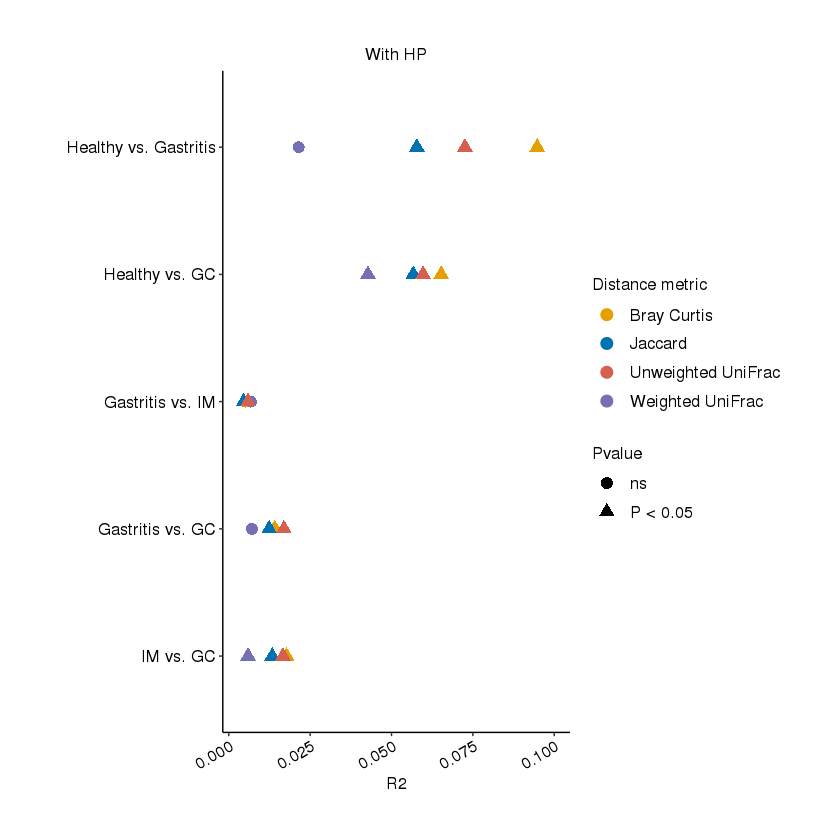

In [106]:
ggplot(data =combined_res , aes(x = R2, y =Compare,color=metric))+ geom_point(aes(shape =Pvalue),size=3)+
theme_MicrobeR() +
theme(panel.border = element_blank(), axis.line = element_line())+ #上右方框去掉了
theme(axis.text.x = element_text(angle = 30, hjust = 1), 
        panel.grid = element_blank(), 
        axis.text = element_text(size = 10,colour = 'black'), 
        axis.title = element_text(size = 10),
        plot.title = element_text(size = 10,hjust = 0.5),
        legend.title = element_text(size = 10),
      legend.text = element_text(size = 10),
     plot.margin=unit(rep(2,4),'lines')
     )+ylab('')+scale_color_manual(values=col)+labs(color='Distance metric') + xlim(0.003,0.1)+
labs(title='With HP')+theme(plot.title = element_text(hjust = 0.5))#
ggsave("figures/dignosis_combined_adonis-no313391.pdf", device="pdf", height=5, width=5.5, useDingbats=F)